In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import diffxpy.api as de
import os

In [2]:
files = os.listdir("./H5ADfiles/")

In [3]:
Remove = []
TgoodID = []
for i in open("./OUTPUT/Testis_Tgood_ID.txt","r").readlines():
    TgoodID.append(i.strip())

TpoorID = []
for i in open("./OUTPUT/Testis_Tpoor_ID.txt","r").readlines():
    TpoorID.append(i.strip())

print("There are "+str(len(TgoodID))+" subjects in Group A.")
print("There are "+str(len(TpoorID))+" subjects in Group B.\n")

There are 146 subjects in Group A.
There are 183 subjects in Group B.



In [4]:
myTissues3=['AnnData_GTEx_v10_Testis.h5ad',
           'AnnData_GTEx_v10_Adrenal Gland.h5ad',
           'AnnData_GTEx_v10_Thyroid.h5ad']

In [5]:
GroupG_SubjIDs = set(TgoodID)
GroupP_SubjIDs = set(TpoorID)
UsedTis = []
NonUsedTis = []

for file in myTissues3:
    if file.count("AnnData_GTEx_v10_") == 1 and file.count(".h5ad") == 1:
        if file not in Remove:
            print(file)
            myadata = 0
            myadata = sc.read("./H5ADfiles/"+file)
            #myadata = myadata[myadata.obs.DTHHRDY != 0.0] ###################注意
            AllID = myadata.obs.SUBJID.to_list()
            TmpA = GroupG_SubjIDs.intersection(set(AllID))
            TmpB = GroupP_SubjIDs.intersection(set(AllID))
            if min([len(TmpA),len(TmpB)]) < 5:
                print("$Group TestisGood subject numbers now is: "+str(len(list(TmpA)))+".")
                print("$Group TestisPoor subject numbers now is: "+str(len(list(TmpB)))+".")
                print("$ "+file+" is removed.\n")
                NonUsedTis.append(file)
            else:
                UsedTis.append(file)
                GroupG_SubjIDs = GroupG_SubjIDs.intersection(set(AllID))
                GroupP_SubjIDs = GroupP_SubjIDs.intersection(set(AllID))
                print("&&&&&&Group TestisGood subject numbers now is: "+str(len(list(GroupG_SubjIDs)))+".")
                print("&&&&&&Group TestisPoor subject numbers now is: "+str(len(list(GroupP_SubjIDs)))+".")
                print("&&&&&&&&&& "+file+" is used.\n")              
     
print("The tissues used here:")
print(UsedTis)
print("The tissues Non-used here:")
print(NonUsedTis)

AnnData_GTEx_v10_Testis.h5ad
&&&&&&Group TestisGood subject numbers now is: 146.
&&&&&&Group TestisPoor subject numbers now is: 183.
&&&&&&&&&& AnnData_GTEx_v10_Testis.h5ad is used.

AnnData_GTEx_v10_Adrenal Gland.h5ad
&&&&&&Group TestisGood subject numbers now is: 43.
&&&&&&Group TestisPoor subject numbers now is: 80.
&&&&&&&&&& AnnData_GTEx_v10_Adrenal Gland.h5ad is used.

AnnData_GTEx_v10_Thyroid.h5ad
&&&&&&Group TestisGood subject numbers now is: 36.
&&&&&&Group TestisPoor subject numbers now is: 59.
&&&&&&&&&& AnnData_GTEx_v10_Thyroid.h5ad is used.

The tissues used here:
['AnnData_GTEx_v10_Testis.h5ad', 'AnnData_GTEx_v10_Adrenal Gland.h5ad', 'AnnData_GTEx_v10_Thyroid.h5ad']
The tissues Non-used here:
[]


In [109]:
Tissues = []
Log2FC_less = []
Log2FC_larger = []
Total = []

myTisDiffResults = {}

for file in UsedTis:
    print("Analysing: $$$ "+file)
    myadata = sc.read("./H5ADfiles/"+file)
    myGenes = myadata.var["Symbol"].to_list()
    myadata.var_names = myGenes
    myadata.var_names_make_unique()
    
    AllID = myadata.obs.SUBJID.to_list()
    TGbool = [x in GroupG_SubjIDs for x in AllID]
    TPbool = [x in GroupP_SubjIDs for x in AllID]
    myadataTG = myadata[TGbool]
    myadataTP = myadata[TPbool]
    myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
    myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)
    myadataGP = ad.concat([myadataTG, myadataTP], axis=0)
    #myadataGP = myadataGP[myadataGP.obs.DTHHRDY != 0.0]    
    #############注意
    myadataGP.X = myadataGP.X.astype(np.float64)
    sc.pp.normalize_total(myadataGP, target_sum=1e4)
    sc.pp.log1p(myadataGP)
    
    test_results = de.test.two_sample(data=myadataGP, # AnnData 对象
                                      grouping=myadataGP.obs["Cluster"],  # 分组列（如细胞聚类结果）
                                      gene_names=myadataGP.var_names,
                                      test="rank")      # 基因名
    
    deg_table = test_results.summary()
    #significant_genes = deg_table[(deg_table["pval"] < 0.01) & (abs(deg_table["log2fc"]) > 0.5)]
    significant_genes = deg_table[(deg_table["qval"] < 0.05) & (deg_table["mean"]>0.01)] #注意假阳性
    significant_genes2 = significant_genes.sort_values(by='log2fc')
    myT = file.split(".h")[0]
    significant_genes2.to_csv("./OUTPUT/Adr_Thy_Testis."+myT+".DE.csv")
    deg_table.to_csv("./OUTPUT/Adr_Thy_Testis."+myT+".2.DE.csv")
    myTisDiffResults[file] = deg_table
    myT2 = myT.split("_v10_")[1]
    Tissues.append(myT2)
    Log2FC_less.append(significant_genes2[significant_genes2['log2fc'] < 0].shape[0])
    Log2FC_larger.append(significant_genes2[significant_genes2['log2fc'] > 0].shape[0])
    Total.append(significant_genes2.shape[0])


myD = {"Tissue":Tissues,"log2fc < 0":Log2FC_less,"log2fc > 0":Log2FC_larger,"Total.dif":Total}
mydf = pd.DataFrame(myD)
mydf = mydf.sort_values(by='Total.dif')
mydf

Analysing: $$$ AnnData_GTEx_v10_Testis.h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_463/2526788225.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_463/2526788225.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


Analysing: $$$ AnnData_GTEx_v10_Adrenal Gland.h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_463/2526788225.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_463/2526788225.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


Analysing: $$$ AnnData_GTEx_v10_Thyroid.h5ad


/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_463/2526788225.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTG.obs["Cluster"] = ["T.good"]*len(GroupG_SubjIDs)
/tmp/ipykernel_463/2526788225.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myadataTP.obs["Cluster"] = ["T.poor"]*len(GroupP_SubjIDs)


,Tissue,log2fc < 0,log2fc > 0,Total.dif
2,Thyroid,16,5,21
1,Adrenal Gland,143,117,260
0,Testis,10181,10791,20972


In [7]:
def transData(file,SubJG,SubJP):
    The_adata = sc.read("./H5ADfiles/"+file)
    myGenes = The_adata.var["Symbol"].to_list()
    The_adata.var_names = myGenes
    The_adata.var_names_make_unique()    
    AllID = The_adata.obs.SUBJID.to_list()
    TAbool = [x in SubJG for x in AllID]
    TBbool = [x in SubJP for x in AllID]
    The_adataTA = The_adata[TAbool]
    The_adataTB = The_adata[TBbool]
    The_adataTA.obs["Cluster"] = ["T.good"]*len(SubJG)
    The_adataTB.obs["Cluster"] = ["T.poor"]*len(SubJP)
    The_adataTATB = ad.concat([The_adataTA, The_adataTB], axis=0)
    
    The_adataTATB.X = The_adataTATB.X.astype(np.float64)
    sc.pp.normalize_total(The_adataTATB, target_sum=1e4)
    sc.pp.log1p(The_adataTATB)
    return The_adataTATB


def plotGene(The_adataTATB,TissueName,group,Gene,): 
    # 将数据转换为 DataFrame
    df = pd.DataFrame({
        'log(CPM + 1)': The_adataTATB[:,Gene].X.flatten(),  # 获取基因表达数据
        group: The_adataTATB.obs['Cluster']            # 分组信息
    })
    plt.close()
    plt.ioff()
    fig, ax = plt.subplots(figsize=(3, 4), constrained_layout=True)
    # 绘制箱线图
    sns.boxplot(
        data=df,
        x=group,
        y='log(CPM + 1)',
        width=0.5,
        #palette='Set2',       # 配色方案
        fill=False,
        showfliers=False,      # 是否显示离群点
        ax=ax
    )
    sns.swarmplot(
        data=df,
        x=group,
        y="log(CPM + 1)",
        hue="Cluster",          # 指定颜色分组列
        palette="Set2",
        size=5,
        alpha=0.7,
        ax=ax
    )

    ax.set_title(Gene, fontstyle="italic", color="black",fontsize=25)
    #plt.xticks(rotation=45)  # 旋转标签

    ax.set_ylabel('log(CPM + 1)',fontsize=20)
    ax.tick_params(axis='x', labelsize=20)
    ax.set_xlabel(TissueName,fontsize=20)
    save_path = "/mnt/h/GTEx/my_plots/Testis_"+TissueName+"."+Gene+".pdf"
    fig.savefig(save_path, dpi=300,transparent=False)
    plt.show(fig)
    plt.close(fig)



In [8]:
myAdrenalGland = transData('AnnData_GTEx_v10_Adrenal Gland.h5ad',GroupG_SubjIDs, GroupP_SubjIDs)

/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_463/2193475084.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  The_adataTA.obs["Cluster"] = ["T.good"]*len(SubJG)
/tmp/ipykernel_463/2193475084.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  The_adataTB.obs["Cluster"] = ["T.poor"]*len(SubJP)


In [13]:
myThyroid = transData('AnnData_GTEx_v10_Thyroid.h5ad',GroupG_SubjIDs, GroupP_SubjIDs)

/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_463/2193475084.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  The_adataTA.obs["Cluster"] = ["T.good"]*len(SubJG)
/tmp/ipykernel_463/2193475084.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  The_adataTB.obs["Cluster"] = ["T.poor"]*len(SubJP)


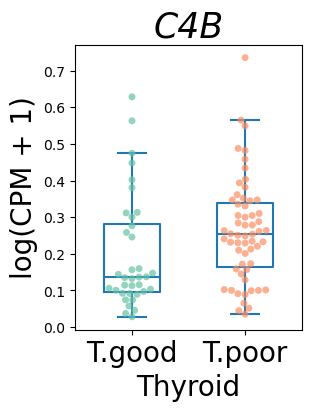

In [14]:
plotGene(myThyroid,"Thyroid","Cluster","C4B")

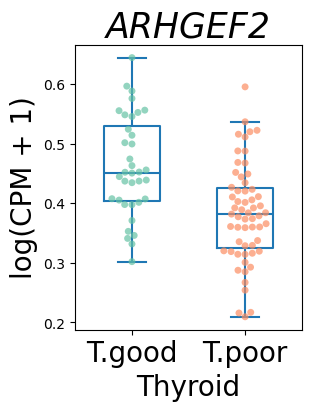

In [15]:
plotGene(myThyroid,"Thyroid","Cluster","ARHGEF2")

In [16]:
myAdrenalGland.obs

,SMPTHNTS,SMTSD,SUBJID,SEX,AGE,DTHHRDY,Cluster
GTEX-11NSD-0226-SM-5A5LR,"2 pieces, well preserved; one section shows me...",Adrenal Gland,GTEX-11NSD,1.0,20-29,0.0,T.good
GTEX-12696-0626-SM-5EGGD,"2 pieces, all cortex, good specimens, minimal fat",Adrenal Gland,GTEX-12696,1.0,60-69,3.0,T.good
GTEX-12WSL-0326-SM-5CVMK,2 pieces; 1 with 1 mm fibrofatty capsule,Adrenal Gland,GTEX-12WSL,1.0,50-59,0.0,T.good
GTEX-13111-0326-SM-5DUXF,2 pieces; one with 80% and other with 40% of e...,Adrenal Gland,GTEX-13111,1.0,50-59,0.0,T.good
GTEX-13O1R-2326-SM-5IJF9,2 pieces; 1 has 50% internal fat; other is fat...,Adrenal Gland,GTEX-13O1R,1.0,60-69,2.0,T.good
...,...,...,...,...,...,...,...
GTEX-YFCO-0126-SM-4W1YT,4 pieces; 3 with attached adipose tissue (up t...,Adrenal Gland,GTEX-YFCO,1.0,40-49,0.0,T.poor
GTEX-ZLFU-0826-SM-4WWBP,2 pieces. Moderate medullary hyperplasia,Adrenal Gland,GTEX-ZLFU,1.0,40-49,0.0,T.poor
GTEX-ZT9X-0126-SM-4YCFC,"2 pieces, all cortex, ~1-1.5mm rim of adherent...",Adrenal Gland,GTEX-ZT9X,1.0,40-49,0.0,T.poor
GTEX-ZUA1-1926-SM-5E45E,2 pieces. 20 & 40% peripheral fat,Adrenal Gland,GTEX-ZUA1,1.0,40-49,2.0,T.poor


In [17]:
myThyroid.obs

,SMPTHNTS,SMTSD,SUBJID,SEX,AGE,DTHHRDY,Cluster
GTEX-11NSD-0126-SM-5987F,"2 pieces, ~2mm colloid cyst, featurs of goiter...",Thyroid,GTEX-11NSD,1.0,20-29,0.0,T.good
GTEX-12696-0326-SM-5EGL4,"2 pieces, regressive changes",Thyroid,GTEX-12696,1.0,60-69,3.0,T.good
GTEX-12WSL-0626-SM-5GCOY,2 pieces; small focus [0.3 mm] parathyroid in ...,Thyroid,GTEX-12WSL,1.0,50-59,0.0,T.good
GTEX-13111-0226-SM-5EQ55,2 pieces; multifocal mild stromal fibrosis com...,Thyroid,GTEX-13111,1.0,50-59,0.0,T.good
GTEX-13O1R-0826-SM-5J2MB,2 pieces; mild lymphocytic infiltrate,Thyroid,GTEX-13O1R,1.0,60-69,2.0,T.good
...,...,...,...,...,...,...,...
GTEX-YFCO-0326-SM-4W1ZP,2 pieces,Thyroid,GTEX-YFCO,1.0,40-49,0.0,T.poor
GTEX-ZLFU-0626-SM-4WWBO,2 pieces,Thyroid,GTEX-ZLFU,1.0,40-49,0.0,T.poor
GTEX-ZT9X-0226-SM-51MT2,"2 pieces, regressive changes/scarring",Thyroid,GTEX-ZT9X,1.0,40-49,0.0,T.poor
GTEX-ZUA1-0926-SM-4YCDX,2 pieces.,Thyroid,GTEX-ZUA1,1.0,40-49,2.0,T.poor


In [18]:
myTestis = transData('AnnData_GTEx_v10_Testis.h5ad',GroupG_SubjIDs, GroupP_SubjIDs)

/home/majunyu/anaconda3/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(
/tmp/ipykernel_463/2193475084.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  The_adataTA.obs["Cluster"] = ["T.good"]*len(SubJG)
/tmp/ipykernel_463/2193475084.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  The_adataTB.obs["Cluster"] = ["T.poor"]*len(SubJP)


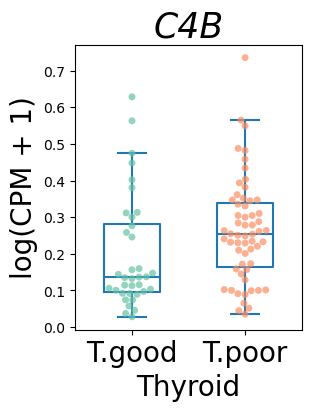

In [27]:
plotGene(myThyroid,"Thyroid","Cluster","C4B")

In [32]:
mydf.to_csv("./OUTPUT/A.T.T.DE.csv")

In [33]:
myTestis[myTestis.obs.Cluster == "T.good"]

View of AnnData object with n_obs × n_vars = 36 × 59033
    obs: 'SMPTHNTS', 'SMTSD', 'SUBJID', 'SEX', 'AGE', 'DTHHRDY', 'Cluster'
    uns: 'log1p'

In [34]:
myTestis[myTestis.obs.Cluster == "T.poor"]

View of AnnData object with n_obs × n_vars = 59 × 59033
    obs: 'SMPTHNTS', 'SMTSD', 'SUBJID', 'SEX', 'AGE', 'DTHHRDY', 'Cluster'
    uns: 'log1p'

In [35]:
myAdrenalGland

AnnData object with n_obs × n_vars = 95 × 59033
    obs: 'SMPTHNTS', 'SMTSD', 'SUBJID', 'SEX', 'AGE', 'DTHHRDY', 'Cluster'
    uns: 'log1p'

In [111]:
myFiles={"Testis":'AnnData_GTEx_v10_Testis.h5ad',
         "Adrenal Gland":'AnnData_GTEx_v10_Adrenal Gland.h5ad',
         "Thyroid":'AnnData_GTEx_v10_Thyroid.h5ad'}

In [117]:
myTisDiffResults['AnnData_GTEx_v10_Testis.h5ad']

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance
0,DDX11L1,1.806724e-01,2.720601e-01,0.236343,0.002546,False,False
1,WASH7P,9.541183e-01,9.678881e-01,0.027250,0.046932,False,False
2,MIR6859-1,4.277841e-01,5.407663e-01,0.751432,0.000295,False,False
3,MIR1302-2HG,9.285016e-02,1.548986e-01,-0.321054,0.000514,False,False
4,FAM138A,6.002152e-01,6.952684e-01,-0.114645,0.000156,False,False
...,...,...,...,...,...,...,...
59028,MT-ND6,5.163572e-09,3.169146e-08,0.245344,3.027757,False,False
59029,MT-TE,1.485179e-04,4.203013e-04,1.294165,0.046130,False,False
59030,MT-CYB,3.397490e-08,1.740836e-07,0.092802,5.171930,False,False
59031,MT-TT,5.789796e-01,6.769516e-01,0.434497,0.003556,False,False


In [126]:
def searchGenePvalues(Gene):
    myPs = {}
    for t in myFiles.keys():
        f = myFiles[t]
        diff = myTisDiffResults[f]
        p = diff[diff.gene == Gene].pval
        myPs[t] = float(p)

    return myPs
    

In [127]:
searchGenePvalues("C3")

/tmp/ipykernel_463/100698177.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  myPs[t] = float(p)


{'Testis': 0.001771304782843795,
 'Adrenal Gland': 0.00027252638942032925,
 'Thyroid': 0.35527271038121455}

In [36]:
myTisAdata = {"Testis":myTestis,
             "Thyroid":myThyroid,
             "Adrenal Gland":myAdrenalGland}

/tmp/ipykernel_463/2025862435.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  myTisDf = pd.concat([myTisDf, df], ignore_index=True)
/tmp/ipykernel_463/100698177.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  myPs[t] = float(p)
/tmp/ipykernel_463/2025862435.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


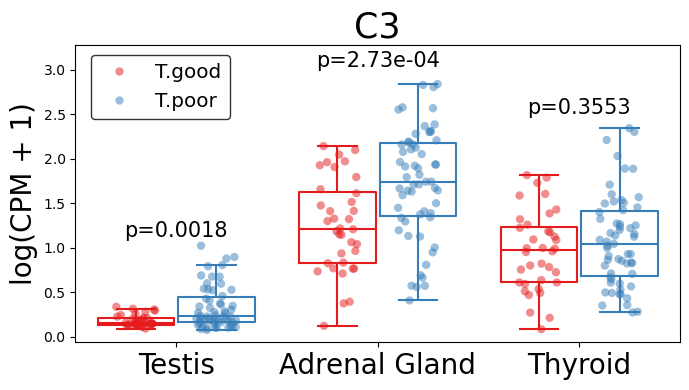

In [158]:
def PlotOneGene(Gene,bbox_to_anchor=(0.01, 1)):
    myTisDf = pd.DataFrame(columns=['log(CPM + 1)', 'Group', 'Tissue'])
    for k in myTisAdata.keys():
        The_adataTATB = myTisAdata[k]
        df = pd.DataFrame({
            'log(CPM + 1)': The_adataTATB[:,Gene].X.flatten(),  # 获取基因表达数据
            'Group': The_adataTATB.obs['Cluster'],            # 分组信息
            'Tissue':k
        })
        myTisDf = pd.concat([myTisDf, df], ignore_index=True)

    fig, ax = plt.subplots(figsize=(7, 4), constrained_layout=True)

    myorder = ["Testis","Adrenal Gland","Thyroid"]
    # 绘制箱线图（显示中位数、四分位数等）
    sns.boxplot(
        data=myTisDf,
        x='Tissue', y='log(CPM + 1)', hue='Group',
        order=myorder,
        palette="Set1",
        #width=0.5,
        dodge = 2,
        gap=0.05,
        showfliers=False,
        legend=False,fill=False
    )

    # 绘制点图（显示数据分布）
    sns.stripplot(
        x='Tissue', y='log(CPM + 1)', hue='Group',
        order=myorder,
        palette="Set1",
        data=myTisDf,
        dodge =0.05,
        jitter=0.2, alpha=0.5, size=6
    )
    #加p值
    myPvalues = searchGenePvalues(Gene)
    for k in myorder:
        p_value = myPvalues[k]
        # 添加p值文本
        x_position = list(myorder).index(k)
        myd = myTisDf[myTisDf["Tissue"]==k]
        ymax = myd['log(CPM + 1)'].max()
        if p_value < 0.001:
            ax.text(x_position, ymax*1.05, 
               f"p={p_value:.2e}", 
               ha='center', va='bottom',size=15)
        else:
            ax.text(x_position, ymax*1.05, 
               f"p={p_value:.4f}", 
               ha='center', va='bottom',size=15)

    current_ylim = ax.get_ylim()
    extension_factor = 1.1  # 延长1.5倍
    # 设置新的y轴范围
    ax.set_ylim(current_ylim[0], current_ylim[1]*extension_factor)
    
    # 添加图例和标题
    plt.title(Gene,size=25)
    plt.xlabel('')
    plt.ylabel('log(CPM + 1)',size=20)
    plt.legend(bbox_to_anchor=bbox_to_anchor,
               loc='upper left',
               fontsize='x-large',
               title =None,
               edgecolor="black")
    plt.xticks(rotation=0,size=20)
    plt.tight_layout()
    save_path = "/mnt/h/GTEx/my_plots/Box_Strip_"+Gene+".pdf"
    fig.savefig(save_path, dpi=300,transparent=False)
    plt.show(fig)
    plt.close(fig)

    return myTisDf

tmp = PlotOneGene("C3")

In [146]:
tmp

,log(CPM + 1),Group,Tissue
0,0.145119,T.good,Testis
1,0.181253,T.good,Testis
2,0.159003,T.good,Testis
3,0.126938,T.good,Testis
4,0.334670,T.good,Testis
...,...,...,...
280,1.590204,T.poor,Adrenal Gland
281,2.839739,T.poor,Adrenal Gland
282,1.644592,T.poor,Adrenal Gland
283,0.406443,T.poor,Adrenal Gland


/tmp/ipykernel_463/209831784.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  myTisDf = pd.concat([myTisDf, df], ignore_index=True)
/tmp/ipykernel_463/100698177.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  myPs[t] = float(p)
/tmp/ipykernel_463/209831784.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


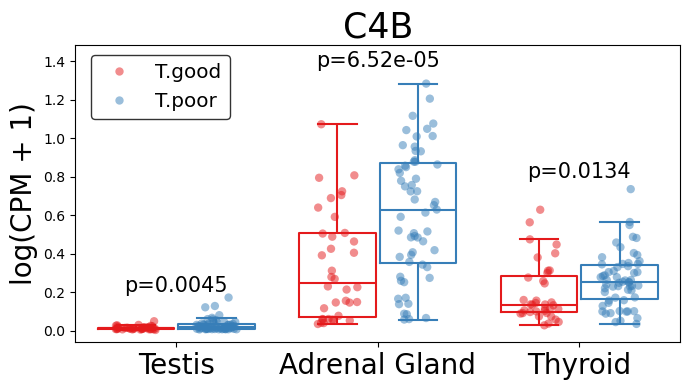

In [153]:
tmp = PlotOneGene("C4B")

/tmp/ipykernel_463/209831784.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  myTisDf = pd.concat([myTisDf, df], ignore_index=True)
/tmp/ipykernel_463/100698177.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  myPs[t] = float(p)
/tmp/ipykernel_463/209831784.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


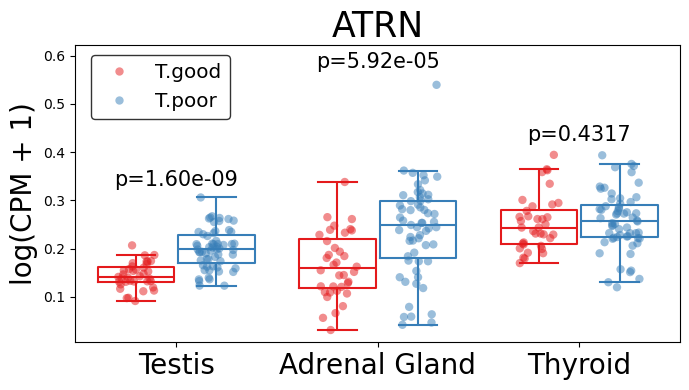

In [154]:
tmp = PlotOneGene("ATRN")

/tmp/ipykernel_463/209831784.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  myTisDf = pd.concat([myTisDf, df], ignore_index=True)
/tmp/ipykernel_463/100698177.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  myPs[t] = float(p)
/tmp/ipykernel_463/209831784.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


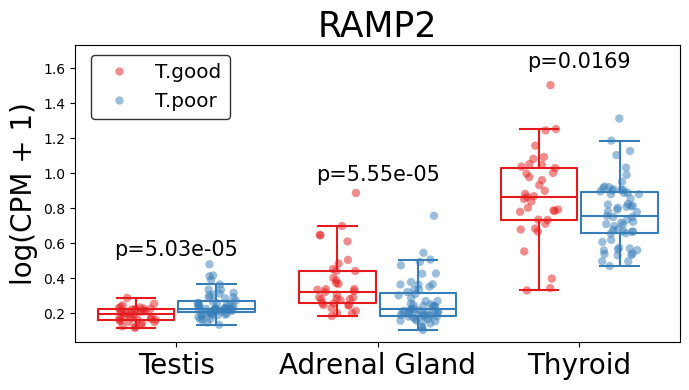

In [155]:
tmp = PlotOneGene("RAMP2")

/tmp/ipykernel_463/209831784.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  myTisDf = pd.concat([myTisDf, df], ignore_index=True)
/tmp/ipykernel_463/100698177.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  myPs[t] = float(p)
/tmp/ipykernel_463/209831784.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


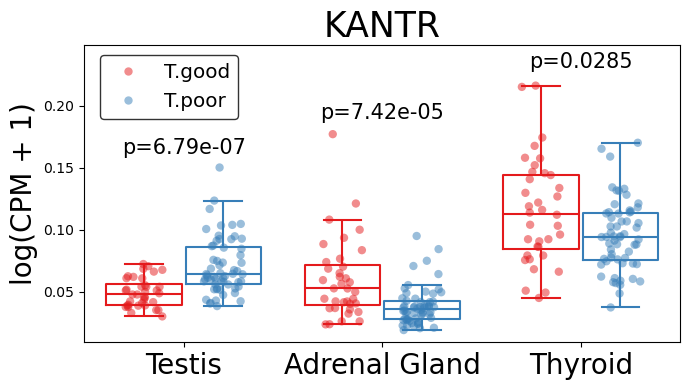

In [156]:
tmp = PlotOneGene("KANTR")

/tmp/ipykernel_463/2025862435.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  myTisDf = pd.concat([myTisDf, df], ignore_index=True)
/tmp/ipykernel_463/100698177.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  myPs[t] = float(p)
/tmp/ipykernel_463/2025862435.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


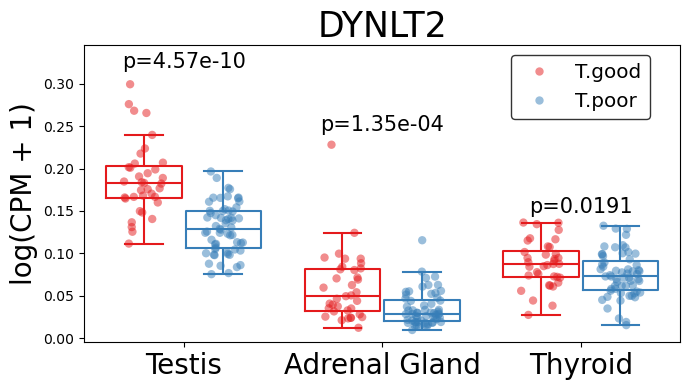

In [161]:
tmp = PlotOneGene("DYNLT2",bbox_to_anchor=(0.7, 1))

/tmp/ipykernel_463/2025862435.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  myTisDf = pd.concat([myTisDf, df], ignore_index=True)
/tmp/ipykernel_463/100698177.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  myPs[t] = float(p)
/tmp/ipykernel_463/2025862435.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


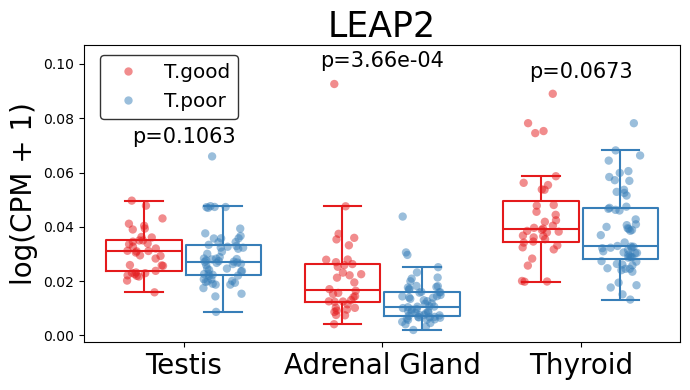

In [163]:
tmp = PlotOneGene("LEAP2")

/tmp/ipykernel_463/2025862435.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  myTisDf = pd.concat([myTisDf, df], ignore_index=True)
/tmp/ipykernel_463/100698177.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  myPs[t] = float(p)
/tmp/ipykernel_463/2025862435.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


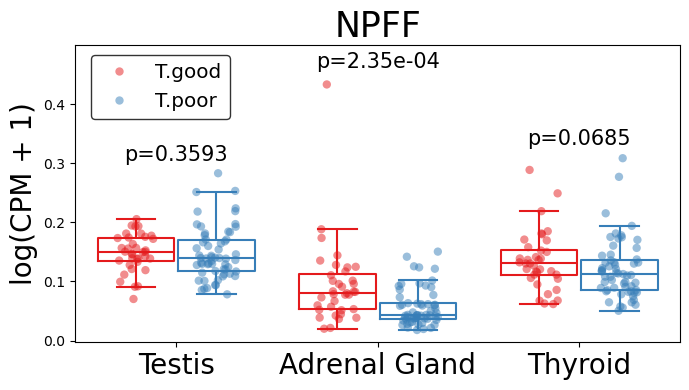

In [164]:
tmp = PlotOneGene("NPFF")